In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(17)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: scheduler='tcp://10.148.1.21:49173' processes=22 cores=88>

_________
# 1. Read dataset (store in face)


In [5]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320/'
face_all = [1,2,4,5,7,8,10,11]

SSU = xr.concat([xr.open_zarr(data_dir+'SSU_f%02d_t00.zarr'%face) for face in face_all], dim='face', compat='equals')
SSV = xr.concat([xr.open_zarr(data_dir+'SSV_f%02d_t00.zarr'%face) for face in face_all], dim='face', compat='equals')

mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid.nc', decode_coords=True)
ds = xr.merge([SSU, SSV, mgrid.isel(face=face_all)])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (face: 8, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 1440)
Coordinates:
    dtime    (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
  * face     (face) int64 1 2 4 5 7 8 10 11
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    CS       (face, j, i) float32 ...
    SN       (face, j, i) float32 ...
    rA       (face, j, i) float32 ...
    dxG      (face, j_g, i) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (face, j, i) fl

In [6]:
#import xgcm
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   i (4320) --> left
  * left     i_g (4320) --> center
Y Axis (periodic):
  * center   j (4320) --> left
  * left     j_g (4320) --> center

In [ ]:
KE = (grid.interp(ds['SSU']**2,'X') + grid.interp(ds['SSV']**2,'Y')) # KE
KE = KE.chunk({'i': 4320, 'j':4320})
KE_tmean = KE.mean(dim='time')
KE_tmean = np.real(KE_tmean).rename('KE_tmean')
KE_tmean = xr.merge([KE_tmean, mgrid.isel(face=face_all)])
file_E = data_dir+'KE_tmean_4320_all_t00.nc'
KE_tmean.to_netcdf(file_E, mode='w')  

In [ ]:
for face in range(ds['face'].size):
 
    KE = (grid.interp(ds['SSU'].isel(face=face)**2,'X') + grid.interp(ds['SSV'].isel(face=face)**2,'Y')) # KE
    KE = KE.chunk({'i': 4320, 'j':4320})
    KE_tmean = KE.mean(dim='time')
    KE_tmean = np.real(KE_tmean).rename('KE_tmean')
    KE_tmean = xr.merge([KE_tmean, mgrid.isel(face=face)])
    file_E = data_dir+'KE_tmean_4320_f%02d_t00.nc'% (face)
    KE_tmean.to_netcdf(file_E, mode='w')  

_______
# 2. Load dataset

In [8]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC4320/'

mKE = xr.open_dataset(data_dir+'KE_tmean_4320_all_t00.nc') 
KE_tmean = mKE.KE_tmean
KE_tmean

<xarray.DataArray 'KE_tmean' (face: 8, j: 4320, i: 4320)>
[149299200 values with dtype=float32]
Coordinates:
  * face     (face) int64 1 2 4 5 7 8 10 11
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    CS       (face, j, i) float32 ...
    SN       (face, j, i) float32 ...
    rA       (face, j, i) float32 ...
    Depth    (face, j, i) float32 ...

In [9]:
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid.nc', decode_coords=True)
grid_face = mgrid.isel(face=face_all)
print(grid_face)

<xarray.Dataset>
Dimensions:  (face: 8, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * face     (face) int64 1 2 4 5 7 8 10 11
    XC       (face, j, i) float32 ...
    YC       (face, j, i) float32 ...
    XG       (face, j_g, i_g) float32 ...
    YG       (face, j_g, i_g) float32 ...
    CS       (face, j, i) float32 ...
    SN       (face, j, i) float32 ...
    rA       (face, j, i) float32 ...
    dxG      (face, j_g, i) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (face, j, i) float32 ...
    rAz      (face, j_g, i_g) float32 ...
    dxC      (face, j, i_g) float32 ...
    dyC      (face, j_g, i) float32 ...
    rAw      (face, j, i_g) flo

In [20]:
KE_tmean = xr.merge([KE_tmean, grid_face])
print(KE_tmean)

<xarray.Dataset>
Dimensions:   (face: 8, i: 4320, i_g: 4320, j: 4320, j_g: 4320)
Coordinates:
  * face      (face) int64 1 2 4 5 7 8 10 11
  * j         (j) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * i         (i) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
    XC        (face, j, i) float32 -37.989582 -37.96875 -37.947918 ...
    YC        (face, j, i) float32 -57.001026 -57.001026 -57.001026 ...
    CS        (face, j, i) float32 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    SN        (face, j, i) float32 6.261379e-13 -6.261379e-13 6.261379e-13 ...
    rA        (face, j, i) float32 1552802.6 1552802.6 1552802.6 1552802.5 ...
    Depth     (face, j, i) float32 3047.2024 3032.884 3033.7307 3074.5486 ...
  * i_g       (i_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * j_g       (j_g) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    XG        (face, j_g, i_g) float32 ...
    YG        (face, j_g, i_g) float32

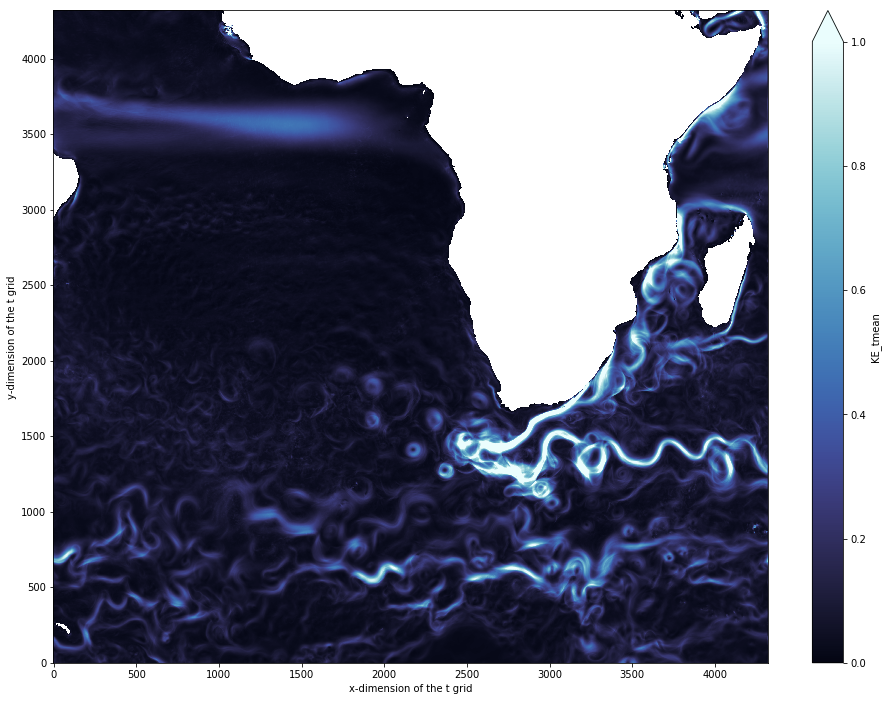

In [10]:
fig = plt.figure(figsize = (16,12))
mKE.KE_tmean.plot(vmin=0, vmax=1, cmap = cm.ice)

In [10]:
ds_subset = (KE_tmean.stack(point=['face','j', 'i']).chunk({'point': 100000}))
print(ds_subset)
print('\n data size: %.1f GB' %(ds_subset.nbytes / 1e9))

<xarray.DataArray 'KE_tmean' (point: 149299200)>
dask.array<shape=(149299200,), dtype=float32, chunksize=(100000,)>
Coordinates:
    XC       (point) float32 dask.array<shape=(149299200,), chunksize=(100000,)>
    YC       (point) float32 dask.array<shape=(149299200,), chunksize=(100000,)>
    CS       (point) float32 dask.array<shape=(149299200,), chunksize=(100000,)>
    SN       (point) float32 dask.array<shape=(149299200,), chunksize=(100000,)>
    rA       (point) float32 dask.array<shape=(149299200,), chunksize=(100000,)>
    Depth    (point) float32 dask.array<shape=(149299200,), chunksize=(100000,)>
  * point    (point) MultiIndex
  - face     (point) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
  - i        (point) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...

 data size: 0.6 GB


In [11]:
E_KE_zonmean = (ds_subset.where(ds_subset.Depth>500).groupby_bins(ds_subset['YC'], np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['point']))
E_KE_zonmean= E_KE_zonmean.chunk({'YC_bins': 1})
E_KE_zonmean = np.real(E_KE_zonmean).rename('E_KE_zonmean')
file_E = data_dir+'E_KE_zonmean_2160.zarr'
%time E_KE_zonmean.to_dataset().to_zarr(file_E, mode='w')

CPU times: user 1min 4s, sys: 6.34 s, total: 1min 10s
Wall time: 1min 12s


In [12]:
ds = xr.open_zarr(data_dir+'E_KE_zonmean_2160.zarr') 
print(ds)

<xarray.Dataset>
Dimensions:       (YC_bins: 121)
Coordinates:
  * YC_bins       (YC_bins) int64 -60 -59 -58 -57 -56 -55 -54 -53 -52 -51 ...
Data variables:
    E_KE_zonmean  (YC_bins) float32 dask.array<shape=(121,), chunksize=(1,)>


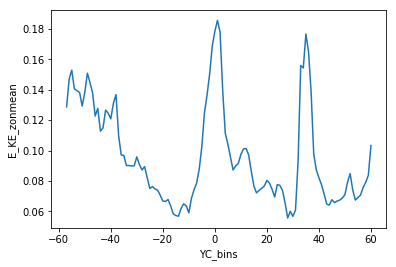

In [13]:
ds.E_KE_zonmean.plot()

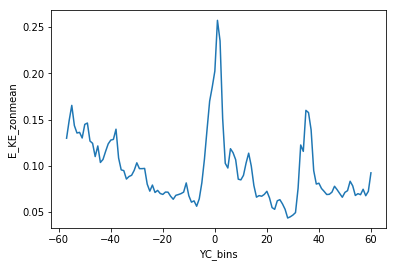

In [28]:
ds.E_KE_zonmean.plot()

______
# 3. Figures

In [30]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52830 remote=tcp://10.148.1.10:43165>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52831 remote=tcp://10.148.1.10:43165>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52832 remote=tcp://10.148.1.10:43165>


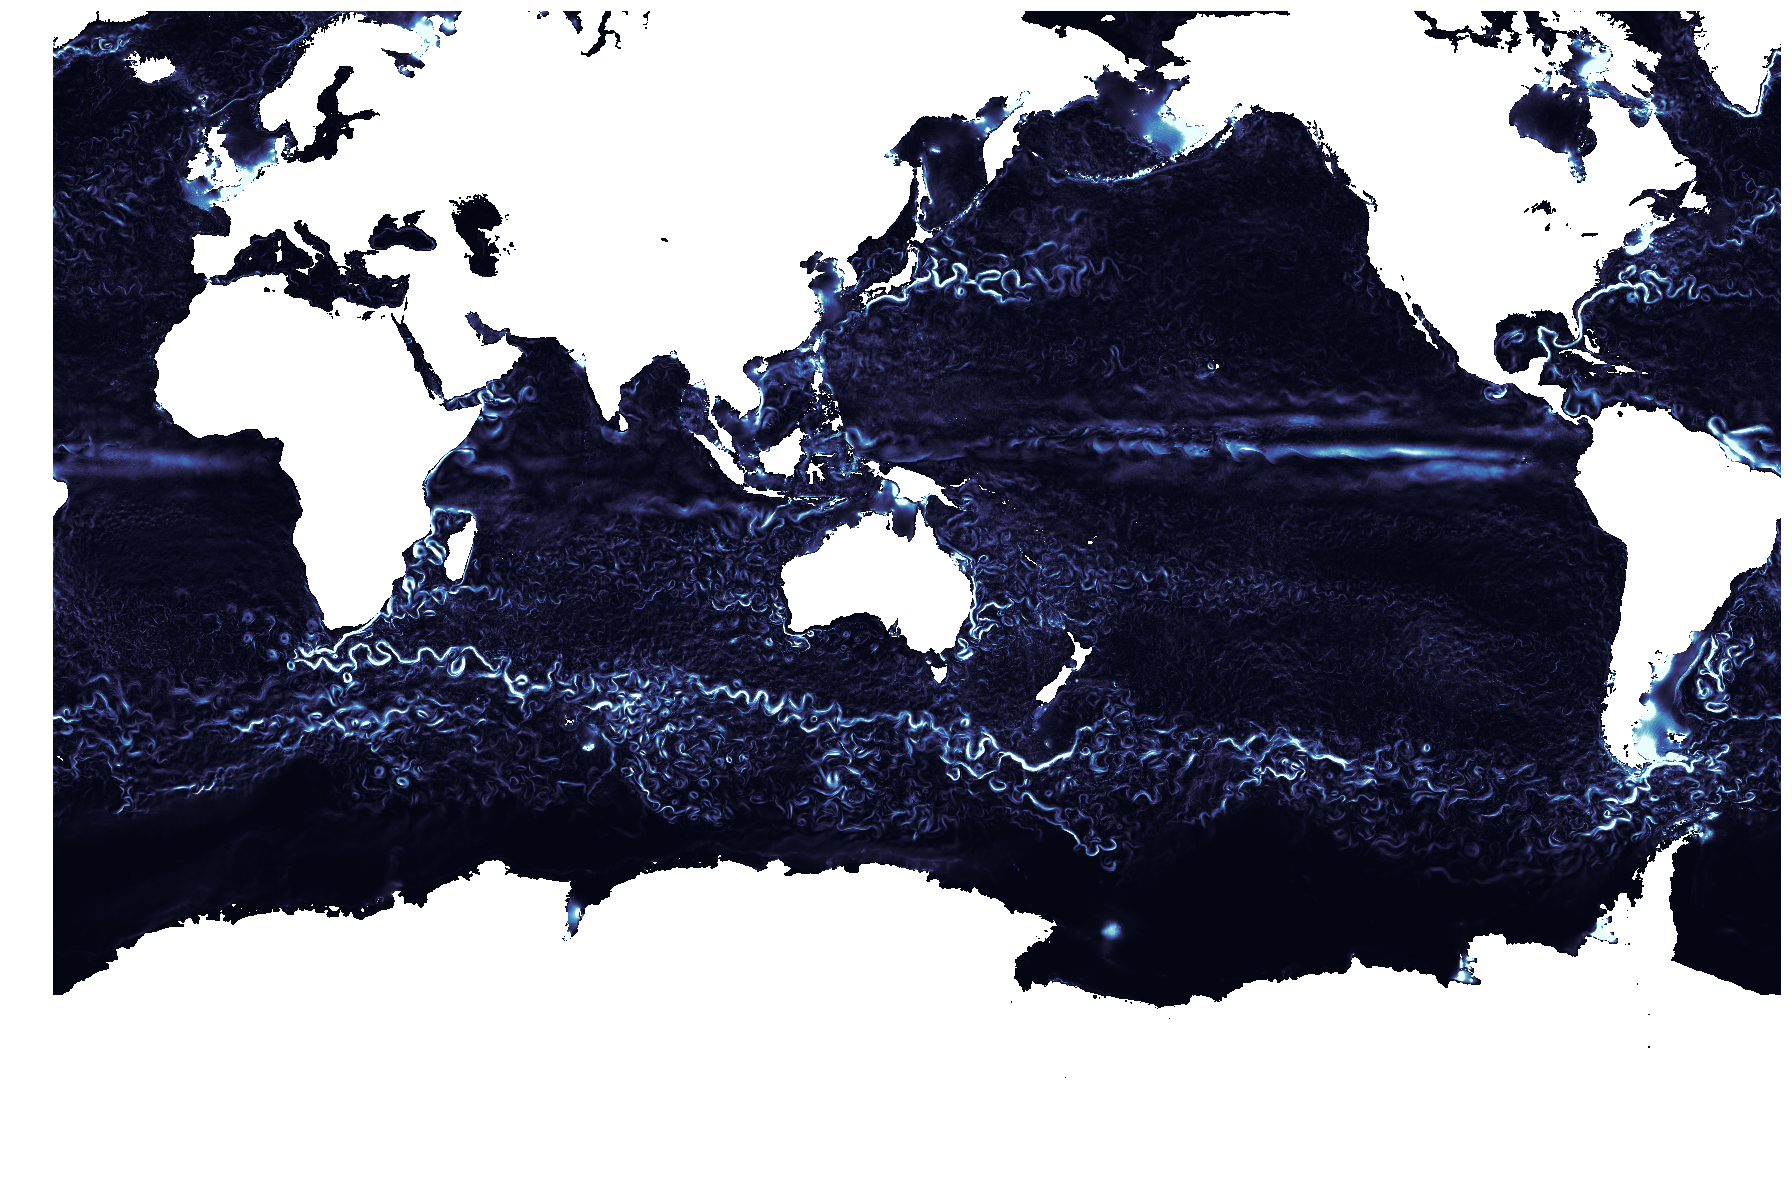

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52837 remote=tcp://10.148.1.10:43165>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://10.148.1.10:52838 remote=tcp://10.148.1.10:43165>


In [10]:
quick_llc_plot(KE_tmean, vmin=0, vmax=1, add_colorbar=False, axis_off=True, cmap = cm.ice)

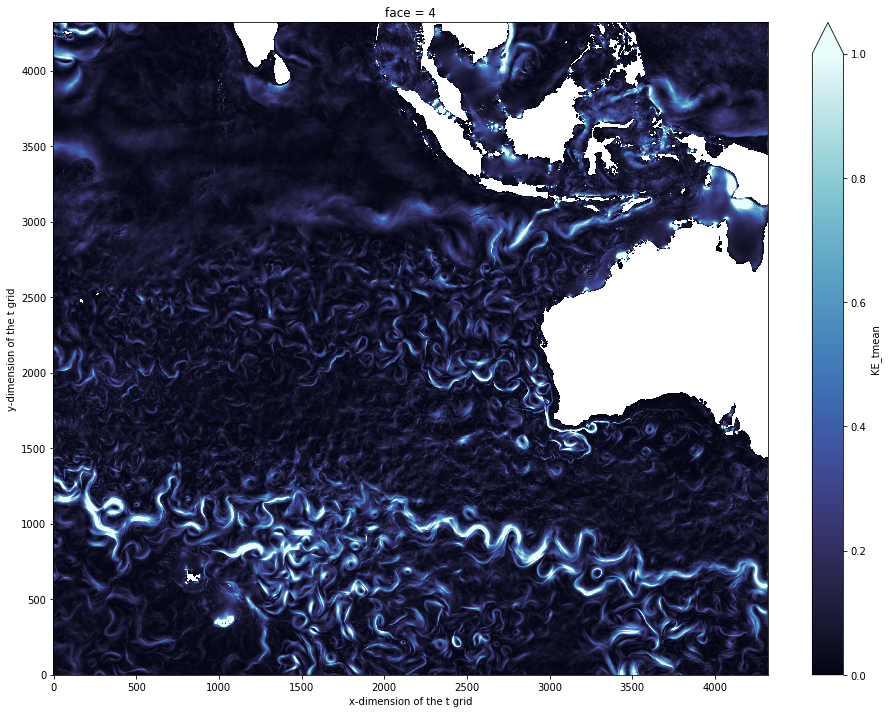

In [15]:
face_plot = 4

fig = plt.figure(figsize = (16,12))
mKE.KE_tmean.isel(face= face_plot).plot(vmin=0, vmax=1, cmap = cm.ice)

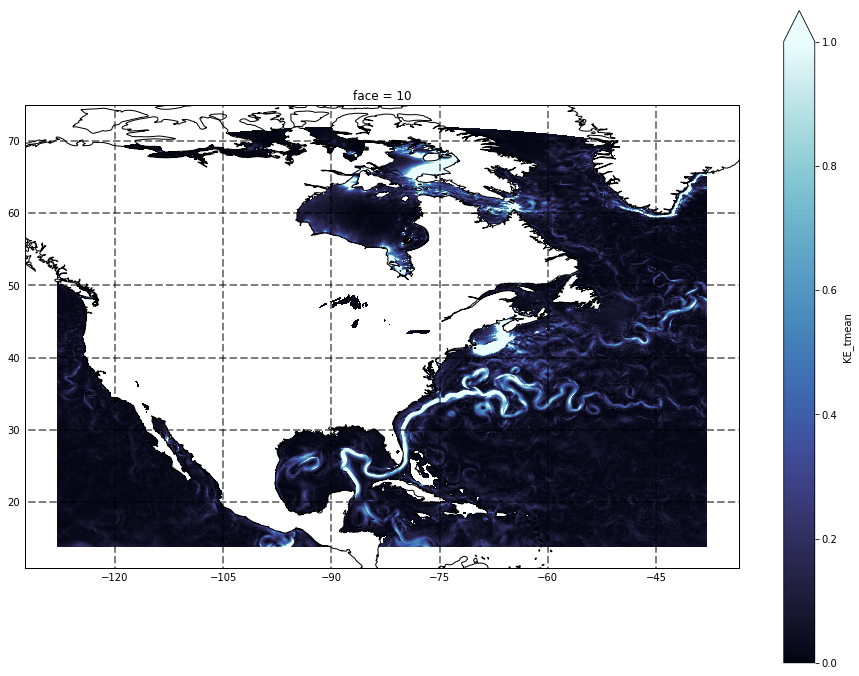

In [16]:
KE_face = mKE.KE_tmean.isel(face= 10)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

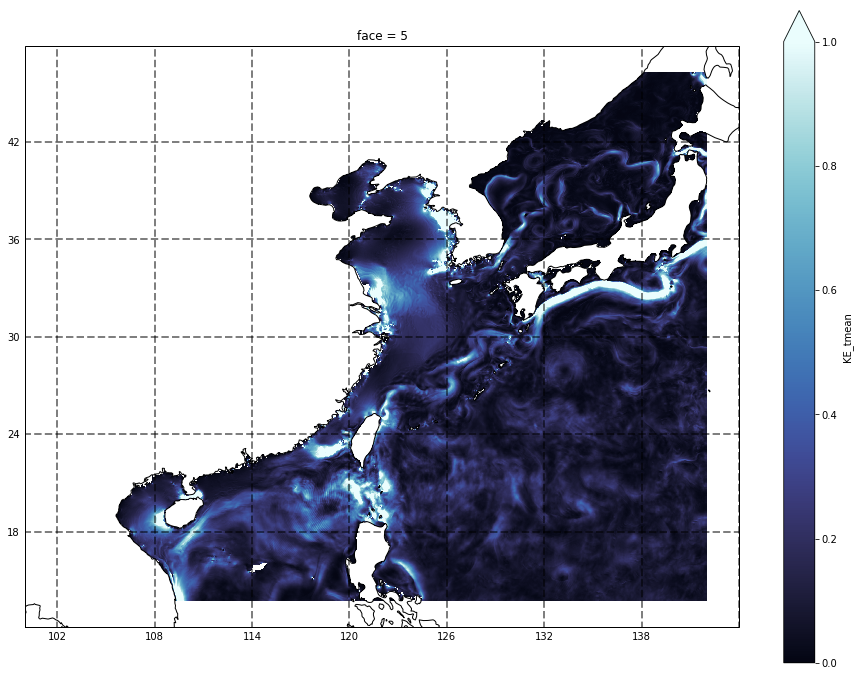

In [21]:
KE_face = mKE.KE_tmean.isel(face= 5, i=slice(2400,4320), j=slice(0,2000))

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

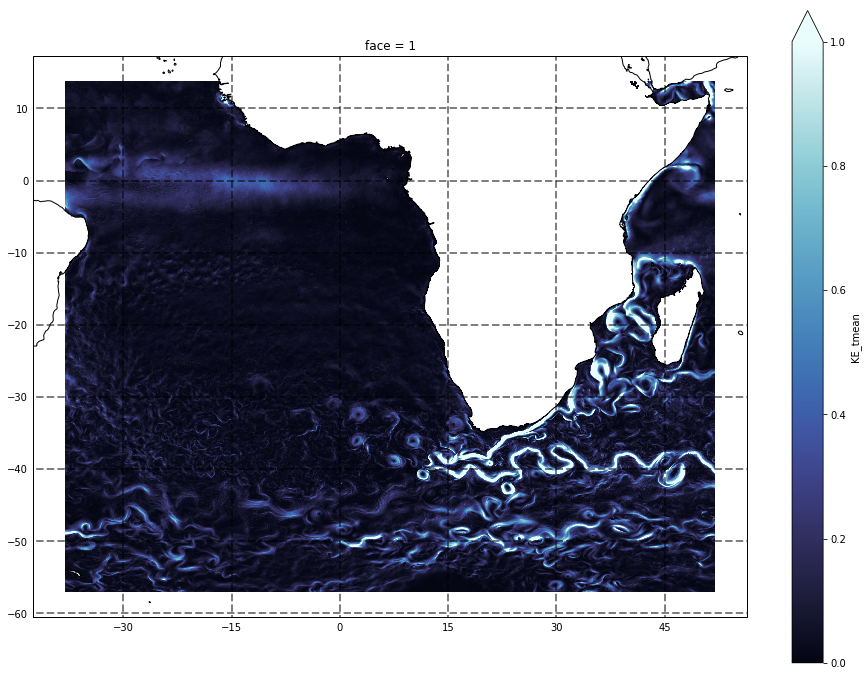

In [18]:
KE_face = mKE.KE_tmean.isel(face= 1)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

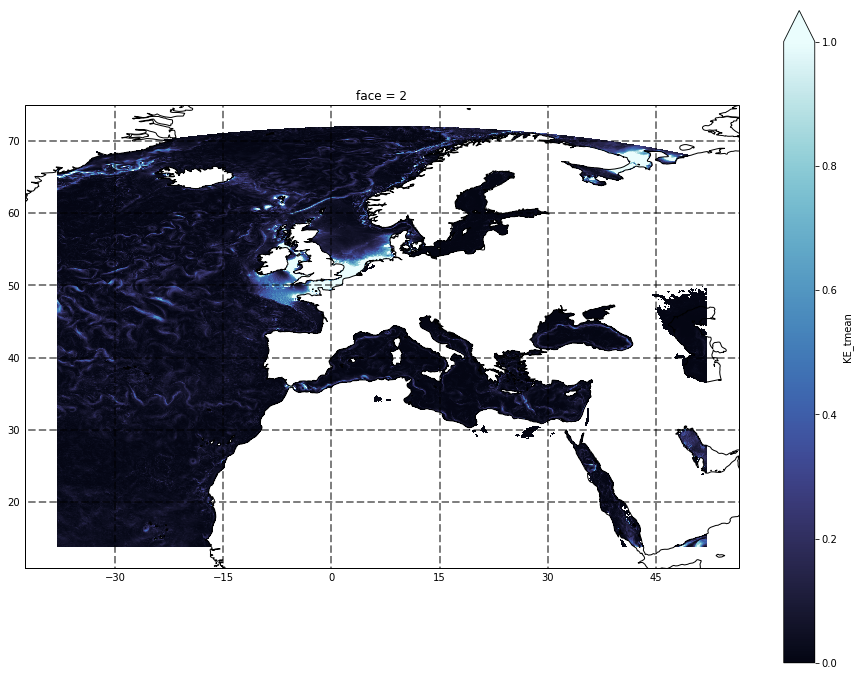

In [19]:
KE_face = mKE.KE_tmean.isel(face= 2)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

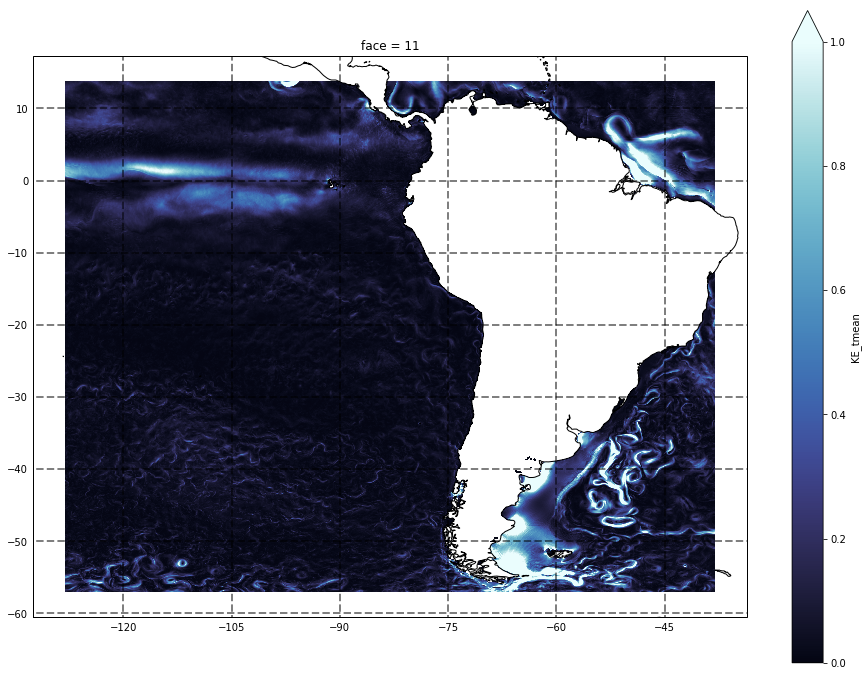

In [20]:
KE_face = mKE.KE_tmean.isel(face= 11)

fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
KE_face.plot.pcolormesh(ax=ax, x='XC', y='YC', transform=ccrs.PlateCarree(), vmin=0, vmax=1, cmap = cm.ice)
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='k', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
ax.coastlines(resolution='50m', color='k')

In [13]:
cluster.scheduler.close()

<Future finished result=None>